In [1]:
from noise_analysis import *
%matplotlib inline

import sys
sys.path.insert(1, 'code_David') # now we can import files from this directory too

import ExampleHelper

np.random.seed(int(time.time()))

from scipy.stats import kstest
from scipy import stats
import matplotlib.cm

def cm2inch(value):
    return value/2.54;

In [2]:
from noise_properties_plotting import *
%matplotlib inline

from neutral_covariance_test import *

from scipy.stats import kstest

%load_ext autoreload

%autoreload 2

In [3]:
from elife_settings import set_elife_settings, ELIFE

set_elife_settings()

In [4]:
# Load all dataframes

# MartinPlatero plankton data

df_ts = {}

path = '../../Data/MartinPlatero/'
files = ['41467_2017_2571_MOESM4_ESM_MartinPlatero_Plankton_Bacteria.csv',
         '41467_2017_2571_MOESM5_ESM_MartinPlatero_Plankton_Eukarya.csv']
keys = ['plankton_bacteria', 'plankton_eukarya']

for i, f in enumerate(files):
    x = pd.read_csv(path+f, na_values='NAN', index_col=0)
    x = x.iloc[:, :-1] # delete last columns which contains details on the otu's
    
    # only keep 200 most abundant species
    sum_x = x.sum(axis='columns')
    
    x = x[sum_x >= np.sort(sum_x)[-200]]
    
    x = x.T # species are in rows instead of columns
    
    x.insert(0, 'time', [int(j[4:7]) for j in x.index]) # day
    
    x = x.groupby('time').agg('mean').reset_index()
    
    x.columns = ['time'] + ['species_%d' % j for j in range(1, len(x.columns))]
    
    df_ts[keys[i]] = x


# David stool data

files = ['../../Data/Faust/25_timeseries/25_timeseries.txt',
         '../../Data/Faust/28_timeseries/28_timeseries.txt']
keys = ['David_stool_A', 'David_stool_B']

for i, f in enumerate(files):
    x = pd.read_csv(f, na_values='NAN', delimiter='\t', header=None)
    
    x = x.T
    
    x.insert(0, 'time', range(len(x)))
    
    x.columns = ['time'] + ['species_%d' % j for j in range(1, len(x.columns))]
    
    df_ts[keys[i]] = x
    
# Caporaso body sites data

areas = ['feces', 'L_palm', 'R_palm', 'tongue']
gender = ['F4', 'M3']

for area in areas:
    for gender_i in gender:
        for taxlevel in range(2,7):
            file = '../../Data/Caporaso/' + gender_i + '_' + area + '_L%d' % taxlevel + '.txt'
            key = 'Caporaso_' + gender_i + '_' + area + '_L%d' % taxlevel 
            
            x = pd.read_csv(file, delimiter='\t', skiprows=1, index_col=0, header=None)
            #x = x[x.sum(axis='rows') > 0]
                        
            x.index = ['time'] + ['species_%d' % j for j in range(1, len(x.index))]
            
            x = x.T
            
            # only keep 200 most abundant species
            if len(x.columns) > 201:
                sum_x = x.sum(axis='rows')
                
                sum_x['time'] = np.inf
                
                sum_x.sort_values(ascending=False, inplace=True)
                
                x = x[sum_x.index.tolist()[:201]]
            
            x.columns = ['time'] + ['species_%d' % j for j in range(1, len(x.columns))]
    
            df_ts[key] = x

# Data from David paper (retrieved from Faust paper)

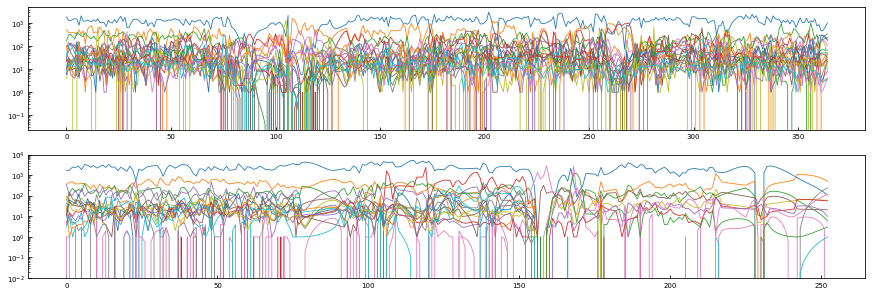

In [4]:
fig = plt.figure(figsize=(15,5))

ax = fig.add_subplot(2,1,1)
ax.plot(df_ts['David_stool_A'].time, df_ts['David_stool_A'].values[:,1::5])
ax.set_yscale('log')

ax = fig.add_subplot(2,1,2)
ax.plot(df_ts['David_stool_B'].time, df_ts['David_stool_B'].values[:,1::5])
ax.set_yscale('log')

plt.show()

# Data from Caporaso

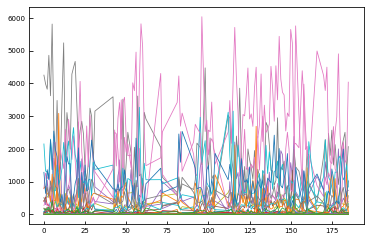

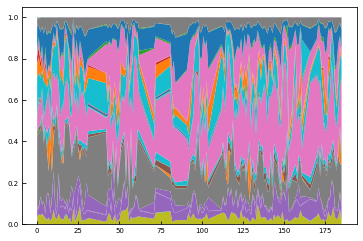

In [5]:
folder = '../../Data/Caporaso/'

file = 'F4_tongue_L6.txt'

d = pd.read_csv(folder + file, delimiter='\t', skiprows=1, index_col=0, header=0).T
t = [float(i) for i in d.index]

plt.plot(t, d.values)

compd = d.values/d.values.sum(axis=1, keepdims=True)

fig, ax = plt.subplots()
ax.stackplot(t, compd.T)
plt.show()

# Rank abundances

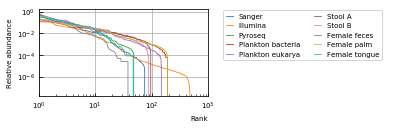

In [8]:
# system dependence

fig = plt.figure(figsize=(ELIFE.TEXTWIDTH,1.8), tight_layout=True)
gs = gridspec.GridSpec(1,2,width_ratios=[1.5,1])

ax = fig.add_subplot(gs[0])

NUM_COLORS = 10

# Static data

path = '../../Data/Arumugam/'
files = ['MetaHIT_41SangerSamples.genus.csv', #'MetaHIT_41SangerSamples.phylum.csv',
          'MetaHIT_85IlluminaSamples.genus.csv', 'Turnbaugh_154Pyroseq16S.genus.csv']
titles = ['Sanger', #'Sanger phylum', 
          'Illumina', 'Pyroseq']

for file, title in zip(files, titles):
    i = 0
    if title == 'Sanger':
        i = 4
        
    d = pd.read_csv(path + file, index_col=0).values[1:,i]
    d /= np.sum(d)
    ax.plot(range(1,len(d)+1), np.sort(d)[::-1], label=title)
 
keys = ['plankton_bacteria', 'plankton_eukarya', 'David_stool_A', 'David_stool_B', 
        'Caporaso_F4_feces_L6', 'Caporaso_F4_L_palm_L6', 'Caporaso_F4_tongue_L6']

titles = ['Plankton bacteria', 'Plankton eukarya', 'Stool A', 'Stool B', 
          'Female feces', 'Female palm', 'Female tongue']

for key, title in zip(keys, titles):
    d = np.copy(df_ts[key].values[0,1:])
    d /= np.sum(d)
    ax.plot(range(1,len(d)+1), np.sort(d)[::-1], label=title)

ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlim([1,1000])
ax.grid()
ax.set_xlabel('Rank', ha='right', x=1)
ax.set_ylabel('Relative abundance')

ax_legend = fig.add_subplot(gs[1])
ax_legend.axis('off')
handles, labels = ax.get_legend_handles_labels()
ax_legend.legend(handles, labels, handlelength=1, ncol=2)

#plt.savefig('figures_elife/supplemental/experimental_rank_abundances.pdf')

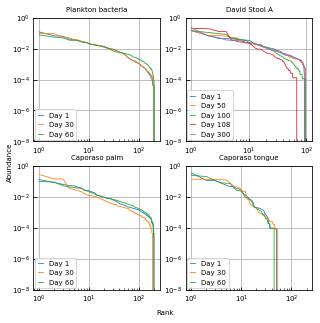

In [10]:
# time dependence of rank abundance curves

fig = plt.figure(figsize=(5,5), tight_layout=True)
gs = gridspec.GridSpec(2,2,wspace=0.2,hspace=0.2)
gs_tot = gridspec.GridSpec(1,1,left=0.08, bottom=0.08)

keys = ['plankton_bacteria', 'David_stool_A', 
        'Caporaso_F4_L_palm_L6', 'Caporaso_F4_tongue_L6']

titles = ['Plankton bacteria', 'David Stool A', 
          'Caporaso palm', 'Caporaso tongue']

for gsi, key, title in zip(gs, keys, titles):
    ax = fig.add_subplot(gsi)
    ax.set_title(title)
    
    timepoints = [1, 30, 60] if key != 'David_stool_A' else [1, 50, 100, 108, 300]
    
    for j in timepoints:
        d = df_ts[key].iloc[j]
        d /= np.sum(d)
        ax.plot(range(1,len(d)+1), np.sort(d)[::-1], label='Day %d' % j)

        ax.set_ylim([1e-8,1])
        ax.legend(loc=3)
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.set_xscale('log')
        ax.grid()

ax = fig.add_subplot(gs_tot[0], frameon=False)
ax.tick_params(left=False, labelleft=False, bottom=False, labelbottom=False)
ax.set_xlabel('Rank')
ax.set_ylabel('Abundance')
        
#plt.savefig('figures/experimental_rank_abundances_timedependence.png')
plt.show()

# Noise colors

In [15]:
def small_setup(composition=None):
    fig = plt.figure(figsize=(6.5,6), tight_layout=True)
    nrows = 2
    ncols = 2
    
    if composition == 'disdx':
        gs = gridspec.GridSpec(nrows,ncols,wspace=0.1,hspace=0.1, right=0.8)
        gs_cbar = gridspec.GridSpec(1, 1, left=0.87)
        gs_tot = gridspec.GridSpec(1,1,top=0.9,bottom=0.08,left=0.07,right=0.8)
    else:
        gs = gridspec.GridSpec(nrows,ncols,wspace=0.1,hspace=0.1)
        gs_cbar = None
        gs_tot = gridspec.GridSpec(1,1,top=0.9,bottom=0.08,left=0.05,right=0.9)

    keys = ['plankton_bacteria', 'David_stool_A', 
            'Caporaso_F4_L_palm_L6', 'Caporaso_F4_tongue_L6']

    titles = ['Plankton bacteria', 'David Stool A', 
              'Caporaso palm', 'Caporaso tongue']
    
    return fig, nrows, ncols, gs, gs_cbar, gs_tot, keys, titles

def large_setup(composition=None):
    fig = plt.figure(figsize=(ELIFE.TEXTWIDTH,2.5), tight_layout=True)
    
    nrows = 3
    ncols = 4
    
    if composition == 'disdx':
        gs = gridspec.GridSpec(nrows,ncols,wspace=0.1,hspace=0.12,top=0.98,bottom=0.12,left=0.08,right=0.85)
        gs_cbar = gridspec.GridSpec(1, 1, top=0.98,bottom=0.1,left=0.88, right=0.9)
    else:
        gs = gridspec.GridSpec(nrows,ncols,wspace=0.1,hspace=0.1,top=0.98,bottom=0.15,left=0.12,right=0.98)
        gs_cbar = None
        gs_tot = gridspec.GridSpec(1,1,top=0.98,bottom=0.06,left=0.05,right=0.98)
    
    if composition == 'disdx':
        gs_tot = gridspec.GridSpec(1,1,top=0.98,bottom=0.06,left=0.03,right=0.85)
    elif composition == 'nc':
        gs_tot = gridspec.GridSpec(1,1,top=0.98,bottom=0.07,left=0.07,right=0.98)
    elif composition == 'dx':
        gs_tot = gridspec.GridSpec(1,1,top=0.98,bottom=0.08,left=0.07,right=0.98)
        
    keys = ['David_stool_A', 'David_stool_B',
            'plankton_bacteria', 'plankton_eukarya',
            'Caporaso_F4_feces_L6', 'Caporaso_M3_feces_L6',
            'Caporaso_F4_L_palm_L6', 'Caporaso_M3_L_palm_L6',
            'Caporaso_F4_R_palm_L6', 'Caporaso_M3_R_palm_L6',
            'Caporaso_F4_tongue_L6', 'Caporaso_M3_tongue_L6']

    titles = ['Stool A', 'Stool B', 
              'Plankton bacteria', 'Plankton eukarya',
              'Female feces', 'Male feces',
                'Female left palm', 'Male left palm',
                'Female right palm', 'Male right palm',
                'Female tongue', 'Male tongue']
    
    return fig, nrows, ncols, gs, gs_cbar, gs_tot, keys, titles



In [16]:
def compare_experimental_data(setup, composition=[], labels = 'in'):
    fig, nrows, ncols, gs, gs_cbar, gs_tot, keys, titles = setup
    
    for i, gsi, key, title in zip(np.arange(len(keys)), gs, keys, titles):
        # make axes and write lable
        if i == 0:
            ax = fig.add_subplot(gsi)
        else:
            ax = fig.add_subplot(gsi, sharex=ax, sharey=ax)
        if labels == 'in':
            ax.text(0.95 if composition == 'ra' else 0.05, 0.95, 
                    title, transform=ax.transAxes,
                  va='top', ha='right' if composition ==  'ra' else 'left' )
        elif labels == 'out':
            ax.set_title(title)

        df = df_ts[key]

        mean = df.mean()
        mean.drop('time', inplace=True)
        
        if composition == 'disdx' or composition == 'disdx2':
            
            def fit_ratio(x):
                x = x[:-1] / x[1:] # ratios of succesive time points
                x = x[np.isfinite(x)] # remove infinities
                x = x[x>0]
                
                if len(x) > 5:
                    a, b, c = stats.lognorm.fit(x, floc=0)  # Gives the paramters of the fit
                    stat, pval = stats.kstest(x, 'lognorm', args=((a, b, c))) # get pvalue for kolmogorov-smirnov test 
                    # (null hypothesis: ratios of succesive time points follow lognorm distribution)

                    return a, b, c, stat, pval
                else:
                    return (np.nan, np.nan, np.nan, np.nan, np.nan)


            dx_ratio = pd.DataFrame(index=df.columns, columns=['s', 'loc', 'scale', 'kstest-statistic', 'kstest-pvalue'])
            dx_ratio.drop('time', axis='rows', inplace=True)

            for idx in dx_ratio.index:
                a, b, c, stat, pval = fit_ratio(df[idx].values)  # b = 0, c = 1
                dx_ratio['s'].loc[idx] = a
                dx_ratio['loc'].loc[idx] = b
                dx_ratio['scale'].loc[idx] = c
                dx_ratio['kstest-statistic'].loc[idx] = stat
                dx_ratio['kstest-pvalue'].loc[idx] = pval
            
            if composition == 'disdx':
                scat = ax.scatter(mean, dx_ratio['s'].values, 
                       c=dx_ratio['kstest-pvalue'].values, vmin=0, vmax=1, cmap='coolwarm', s=3) #, label=param)
            elif composition == 'disdx2':
                def find_ss_selfint(x):
                    amplitude = 2.10E+00 
                    x0 = 2.87E+00
                    k = 1.14E+00
                    offset = -1.77E+00

                    return 10**( -1/x0 * np.log(amplitude/(x-offset) - 1) + k)

                ns = noise_color(df_ts[key])['slope_linear']
                
                selfints = find_ss_selfint(ns.values) / mean.values #.flatten()

                scat = ax.scatter(mean * selfints, dx_ratio['s'].values, 
                       c=dx_ratio['kstest-pvalue'].values, vmin=0, vmax=1, cmap='coolwarm', s=3) #, label=param)
        
        
            #ax.set_xlim([0.1*np.nanmin(mean.values), 10*np.nanmax(mean.values)])
            #ax.set_ylim([0.5*np.nanmin(dx_ratio['s'].values), 5*np.nanmax(dx_ratio['s'].values)])

            ax.set_yscale('log')
            ax.set_xscale('log')
        
        if composition == 'nc':
            vmin = 0.1*mean.min()
            vmax = 10*mean.max()

            ns = noise_color(df_ts[key])['slope_linear']
            ax.scatter(mean, ns, s=3)

            xx = np.linspace(2, -3, 500).reshape([500, 1])
            ax.imshow(xx, cmap=noise_cmap_ww, vmin = noise_lim[0], vmax= noise_lim[1], extent=(1e-3, 2e5, -3, 2),
                         aspect='auto', alpha=0.75)

            ax.set_xscale('log')
        
        if composition == 'dx':
            dx = pd.DataFrame(index=df.columns, columns=['abs_dx'])
            dx.drop('time', axis='rows', inplace=True)

            for idx in dx.index:
                dx['abs_dx'].loc[idx] = np.nanmean(abs(df[idx].values[1:] - df[idx].values[:-1]))

            ax.scatter(mean, dx['abs_dx'].values, s=3)

            p_lin = np.polyfit(np.log10(mean.astype(np.float64)), np.log10(dx.astype(np.float64)), deg=1, cov=False)

            xx = [np.nanmin(mean.values), np.nanmax(mean.values)]
            ax.plot(xx, 10**(p_lin[1] + p_lin[0]*np.log10(xx)), c = 'k', linewidth=0.5)            
            
            ax.text(0.95, 0.05, r'y $\propto$ x$^{%.2f}$' % p_lin[0], transform=ax.transAxes,
              va='bottom', ha='right')
        
            ax.set_yscale('log')
            ax.set_xscale('log')
        
        if composition == 'ra':
            timepoints = [1, 30, 60] if key != 'David_stool_A' else [1, 50, 100, 108, 300]

            for j in timepoints:
                d = np.copy(df_ts[key].iloc[j])
                d /= np.sum(d)
                ax.plot(range(1,len(d)+1), np.sort(d)[::-1], label='Day %d' % j)

                ax.set_ylim([1e-8,1])
                ax.legend(loc=3)
                ax.set_xscale('log')
                ax.set_yscale('log')                
        
        ax.grid()

        if i%ncols != 0:
            ax.tick_params(axis="both", left=True, labelleft=False)
        if i < (nrows-1)*ncols:
            ax.tick_params(axis="both", bottom=True, labelbottom=False)

    if composition == 'disdx' or composition == 'disdx2':
        ax_cbar = fig.add_subplot(gs_cbar[0])
        fig.colorbar(scat, cax=ax_cbar)
        ax_cbar.set_ylabel('P-value lognormal fit')
    
    # add labels (common for all subplots)
    ax = fig.add_subplot(gs_tot[0], frameon=False)
    ax.set_xticks([])
    ax.set_yticks([])
    
    if composition == 'ra':
        ax.set_xlabel('Rank', ha='right', x=1)
    elif composition == 'disdx2':
        ax.set_xlabel(r'Mean abundance $\times$ associated self-interaction', ha='right', x=1) 
    else:
        ax.set_xlabel('Mean abundance', ha='right', x=1) 
    
    if composition == 'nc':
        ax.set_ylabel('Slope power spectral density')
    elif composition == 'disdx' or composition == 'disdx2':
        ax.set_ylabel('Width distribution of ' + r'$x(t+\delta t) / x(t)$')
    elif composition == 'dx':
        ax.set_ylabel(r'$\langle \vert x(t + \delta t) - x(t) \vert \rangle$')
    elif composition == 'ra':
        ax.set_ylabel('Abundance') 




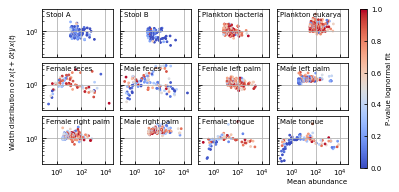

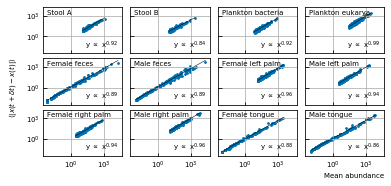

In [17]:
#compare_experimental_data(small_setup('ra'), composition='ra', labels = 'in')

#compare_experimental_data(large_setup('nc'), composition='nc', labels = 'in')
#plt.savefig('figures_elife/supplemental/experimental_noise_color3.pdf')

compare_experimental_data(large_setup('disdx'), composition='disdx', labels = 'in')
plt.savefig('figures_elife/supplemental/experimental_width_step3.pdf')

#compare_experimental_data(large_setup('disdx'), composition='disdx2', labels = 'in')
#plt.savefig('figures_elife/supplemental/experimental_width_step4.pdf')

compare_experimental_data(large_setup('dx'), composition='dx', labels = 'in')
plt.savefig('figures_elife/supplemental/experimental_step3.pdf')

plt.show()

# Timestep distribution

First test some transformations, to find the best one

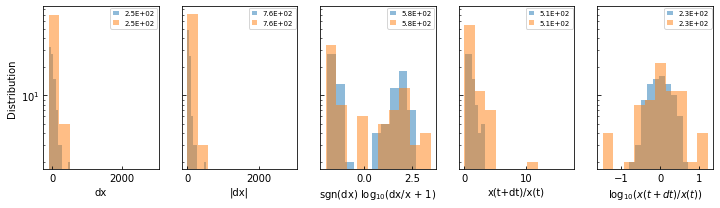

In [16]:
def dx(x):
    x = ((x[1:] - x[:-1])/x[:-1])*1e2
    x = x[np.isfinite(x)]
    return x

def absolute_dx(x):
    x = ((x[1:] - x[:-1])/x[:-1])*1e2
    x = x[np.isfinite(x)]
    return abs(x)

def logmodulus_dx(x):
    x = ((x[1:] - x[:-1])/x[:-1])*1e2
    x = x[np.isfinite(x)]
    return np.sign(x) * np.log10(abs(x) + 1)

def ratio(x):
    x = x[:-1]/x[1:]
    x = x[np.isfinite(x)]
    return x

def logratio(x):
    x = x[:-1]/x[1:]
    x = np.log10(x)
    x = x[np.isfinite(x)]
    return x

transformations = [dx, absolute_dx, logmodulus_dx, ratio, logratio]
labels = ['dx', '|dx|', 'sgn(dx) log$_{10}$(dx/x + 1)', 'x(t+dt)/x(t)', 'log$_{10}(x(t+dt)/x(t))$']

key = 'plankton_bacteria'
df = df_ts[key]

# plot different mean abundances, first sort the species
sorted_idces = df.mean().sort_values().index.tolist()[::-1]
sorted_idces.remove('time')

mean = df.mean()

fig = plt.figure(figsize=(12,3), tight_layout=True)
gs = gridspec.GridSpec(1,5,wspace=0.2)

for idx in [sorted_idces[0], sorted_idces[-1]]:
    x = df[idx].values
        
    for i, gsi, transformation, label in zip(np.arange(len(labels)), gs, transformations, labels):
        if i == 0:
            ax = fig.add_subplot(gsi)
            ax.set_ylabel('Distribution')
        else:
            ax = fig.add_subplot(gsi, sharey=ax)
            ax.tick_params(left=True, labelleft=False)
        
        ax.set_xlabel(label)
    
        transf_x = transformation(x)
        
        ax.hist(transf_x, alpha=0.5, label='%.1E' % mean[i]) #, bins = np.linspace(-2,4,31))        
        
        ax.legend()
        ax.grid()

    #ax.set_ylim([1e-8,1])
    ax.set_yscale('log')
        
#plt.savefig('figures/experimental_timestep.png')
plt.show()

a = 0.292555901954 , b = 0 , c = 20.6882335068
log(c) = 3.02956510903


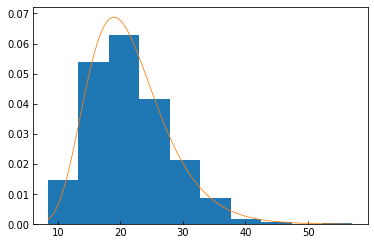

In [15]:
# understand lognormal

x = 0.3 * np.random.randn(1000) + 3 # normally  distributed values

y = np.exp(x) # these values have lognormal distribution

a, b, c = stats.lognorm.fit(y, floc=0)

print("a =", a, ", b =", b, ", c =", c) #(1.9780155814544627, 0, 1070.4207866985835) so, sigma = 0.316706568952 approx 0.3
print("log(c) =", np.log(c)) #yields 2.99728756217 approx 3.0

x_fit = np.linspace(min(y), max(y), 100)
pdf_fitted = stats.lognorm.pdf(x_fit,a,b,c) #Gives the PDF

plt.hist(y, normed=True)
plt.plot(x_fit, pdf_fitted)

Fit lognormal through ratio

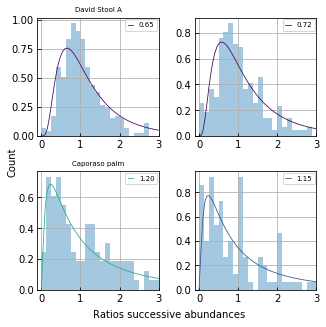

In [13]:
from scipy import stats

fig = plt.figure(figsize=(5,5), tight_layout=True)
gs = gridspec.GridSpec(2,2,wspace=0.3,hspace=0.3)
gs_tot = gridspec.GridSpec(1,1, left=0.08, bottom=0.08)

keys = ['David_stool_A',
        'Caporaso_F4_L_palm_L6']

titles = ['David Stool A', 
          'Caporaso palm']

def ratio(x):
    x = x[:-1]/x[1:]
    x = x[np.isfinite(x)]
    return x

def fit_ratio(x):
    # Return the parameters of the fit and the goodness of fit values

    x = x[:-1]/x[1:]
    x = x[np.isfinite(x)]
    
    a, b, c = stats.lognorm.fit(x,floc=0)
    stat, pval = kstest(x, 'lognorm', args=((a,b,c)))
    return a, b, c, stat, pval

cmap = matplotlib.cm.get_cmap('viridis')

for i, key, title in zip(range(len(keys)), keys, titles):
    ax1 = fig.add_subplot(gs[2*i])
    ax2 = fig.add_subplot(gs[2*i+1])
    
    ax1.set_title(title)
    
    df = df_ts[key]
    
    # plot different mean abundances, first sort the species
    sorted_idces = df.mean().sort_values().index.tolist()[::-1]
    sorted_idces.remove('time')
    
    mean = df.mean()
        
    for i, ax in zip([sorted_idces[3], sorted_idces[-3]], [ax1, ax2]):
        x = df[i].values
        
        x_transf = ratio(x)
        
        a, b, c, stat, pval = fit_ratio(x)  # b = 0, c = 1

        x_fit = np.linspace(0,5,100)
        pdf_fitted = stats.lognorm.pdf(x_fit,a,b,c) #Gives the PDF
        
        ax.hist(x_transf, alpha=0.4, normed=True, bins = np.linspace(0,20,161)) #, label='%.1E' % mean[i],)
        c = cmap(pval)
        ax.plot(x_fit, pdf_fitted, c=c, label='%.2f'%a)
        
        ax.set_xlim([-0.1,3])
        ax.legend() #loc=3)
        #ax.set_yscale('log')
        ax.grid()

ax = fig.add_subplot(gs_tot[0], frameon=False)
ax.tick_params(left=False, labelleft=False, bottom=False, labelbottom=False)
ax.set_ylabel('Count')
ax.set_xlabel('Ratios successive abundances')
        
#plt.savefig('figures/lognorm_ratios_abundances.png')
#plt.savefig('figures/presentationSophie/12_fit_lognorm_ratios_abundances.pdf')
plt.show()

[1.74E-01 1.77E+00 2.60E+00 5.00E+00 1.50E+00 1.00E+00 4.00E+00 5.00E-01
 1.00E+00 4.00E-01 5.00E-01 2.00E+00 3.33E-01 3.00E+00 1.00E+00 2.00E+00
 1.00E+00 5.00E-01 5.00E-01 2.00E+00 3.33E-01 1.00E+00 1.00E+00]


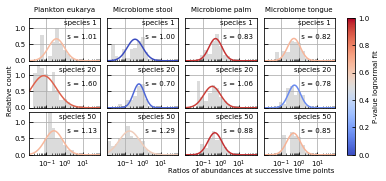

In [5]:
fig = plt.figure(figsize=(ELIFE.TEXTWIDTH,2.5), tight_layout=True)

nrow = 3
ncol = 4

gs = gridspec.GridSpec(nrow,ncol,wspace=0.1,hspace=0.1, left=0.08, bottom=0.12, right=0.85)
gs_tot = gridspec.GridSpec(1,1, bottom=0.07, left=0.05, right=0.85)
gs_cbar = gridspec.GridSpec(1, 1, left=0.88, bottom= 0.12, right=0.9)

gs = np.array([[gs[i,j] for j in range(ncol)] for i in range(nrow)])

keys = ['plankton_eukarya', 'David_stool_A',
        'Caporaso_F4_L_palm_L6', 'Caporaso_F4_tongue_L6']

titles = ['Plankton eukarya', 'Microbiome stool', 
          'Microbiome palm', 'Microbiome tongue']

def ratio(x):
    x = x[:-1]/x[1:]
    x = x[np.isfinite(x)]
    return x

def fit_ratio(x):
    x = x[:-1] / x[1:] # ratios of succesive time points
    x = x[np.isfinite(x)] # remove infinities
    x = x[x>0] 
    
    if len(x) > 5:
        a, b, c = stats.lognorm.fit(x, floc=0)  # Gives the paramters of the fit
        stat, pval = stats.kstest(x, 'lognorm', args=((a, b, c))) # get pvalue for kolmogorov-smirnov test 
        # (null hypothesis: ratios of succesive time points follow lognorm distribution)
    
        #a, b = stats.norm.fit(x) #, floc=0)  # Gives the paramters of the fit
        #c = 0
        #stat, pval = stats.kstest(x, 'norm', args=((a, b))) # get pvalue for kolmogorov-smirnov test 
        
        return a, b, c, stat, pval
    else:
        return (np.nan, np.nan, np.nan, np.nan, np.nan)

cmap = matplotlib.cm.get_cmap('coolwarm')


for i, key, title in zip(np.arange(len(keys)), keys, titles):
    df = df_ts[key]

    # plot different mean abundances, first sort the species
    sorted_idces = df.mean().sort_values().index.tolist()[::-1]
    sorted_idces.remove('time')

    mean = df.mean()
    
    for j, gsi, num in zip(np.arange(nrow), gs[:,i], [1, 20, 50]):
        if i == 0 and j == 0:
            ax = fig.add_subplot(gsi)
        else:
            ax = fig.add_subplot(gsi, sharey=ax)
        
        if j == 0:
            ax.set_title(title)

        idx = sorted_idces[num]
        
        x = df[idx].values

        x_transf = x[:-1] / x[1:] # ratios of succesive time points
        x_transf = x_transf[np.isfinite(x_transf)] # remove infinities
        x_transf = x_transf[x_transf > 0]
        
        a, b, c, stat, pval = fit_ratio(x)

        bound = 1.95

        x_fit = np.logspace(-bound,bound,100)
        pdf_fitted = stats.lognorm.pdf(x_fit,a,b,c) #Gives the PDF
        #pdf_fitted = stats.norm.pdf(x_fit,a,b) #Gives the PDF

        ax.hist(x_transf, normed=True, color='lightgrey', alpha=0.8,
                bins = np.logspace(-bound,bound,20))
        ax.plot(x_fit, pdf_fitted, color=cmap(pval), linewidth=1.5)
        ax.grid()

        ax.set_xscale('log')
        ax.set_xlim([10**(-bound),10**bound])

        if i > 0:
            ax.tick_params(axis="both", left=True, labelleft=False)
        if j < nrow - 1:
            ax.tick_params(axis="both", bottom=True, labelbottom=False)

        label = 'species %d' % num + '\n \n s = %.2f' % a

        ax.text(0.95, 0.95, label, transform=ax.transAxes,
              va='top', ha='right')
        
        if i == 3 and j == 2:
            print(x_transf)
            
            
ax.set_ylim([0, 1.3])

ax_tot = fig.add_subplot(gs_tot[0], frameon=False)
ax_tot.set_ylabel('Relative count')
ax_tot.set_xlabel('Ratios of abundances at successive time points', ha='right', x=1)
ax_tot.set_xticks([])
ax_tot.set_yticks([])

ax_cbar = fig.add_subplot(gs_cbar[0])
mpl.colorbar.ColorbarBase(ax_cbar, cmap='coolwarm',
                            orientation='vertical')

ax_cbar.set_ylabel('P-value lognormal fit')

plt.savefig('figures_elife/supplemental/lognorm_ratios_abundances3.pdf')
plt.show()

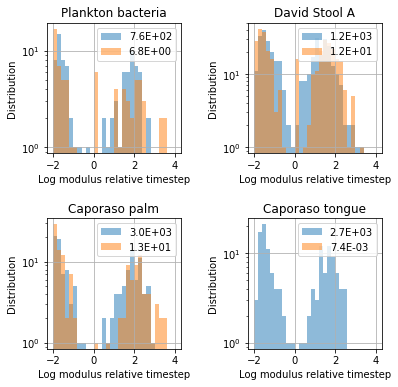

In [57]:
fig = plt.figure(figsize=(6,6), tight_layout=True)
gs = gridspec.GridSpec(2,2,wspace=0.5,hspace=0.5)

keys = ['plankton_bacteria', 'David_stool_A', 
        'Caporaso_F4_L_palm_L6', 'Caporaso_F4_tongue_L6']

titles = ['Plankton bacteria', 'David Stool A', 
          'Caporaso palm', 'Caporaso tongue']

for gsi, key, title in zip(gs, keys, titles):
    ax = fig.add_subplot(gsi)
    ax.set_title(title)
    
    df = df_ts[key]
    
    # plot different mean abundances, first sort the species
    sorted_idces = df.mean().sort_values().index.tolist()[::-1]
    sorted_idces.remove('time')
    
    mean = df.mean()
        
    for i in [sorted_idces[0], sorted_idces[-1]]:
        # Log-modulus transformation
        # L(x) = sign(x) * log(|x| + 1)
        
        x = df[i].values
        x = ((x[1:] - x[:-1])/x[:-1])*1e2
        
        x = x[np.isfinite(x)]
        x = np.sign(x) * np.log10(abs(x) + 1)
        
        ax.hist(x, alpha=0.5, label='%.1E' % mean[i], bins = np.linspace(-2,4,31))

    #ax.set_ylim([1e-8,1])
    ax.legend() #loc=3)
    ax.set_yscale('log')
    ax.set_ylabel('Distribution')
    ax.set_xlabel('Log modulus relative timestep')
    ax.grid()

#plt.savefig('figures/experimental_timestep.png')
plt.show()

# Neutrality

In [5]:
from scipy.interpolate import interp1d
from fractions import gcd

def keys_titles_experimental():
    keys = ['plankton_bacteria', 'plankton_eukarya', 'David_stool_A', 'David_stool_B']

    titles = ['Plankton bacteria', 'Plankton eukarya', 'David Stool A', 'David Stool B']

    areas = ['feces', 'L_palm', 'R_palm', 'tongue']
    gender = ['F4', 'M3']

    for area in areas:
        for gender_i in gender:
            for taxlevel in range(2,7):
                keys += ['Caporaso_' + gender_i + '_' + area + '_L%d' % taxlevel]
                titles += [gender_i + ' ' + area + ' L%d' % taxlevel]
    return keys, titles

def calculate_neutrality(keys):    
    neutrality = pd.DataFrame(index = keys, columns = ['KL', 'NCT'])

    for key in keys:
        if True: #np.isnan(neutrality['NCT'].loc[key]):
            if np.isnan(neutrality['KL'].loc[key]):
                print(df_ts[key].columns)
                if key.startswith('Caporaso'):
                    neutrality['KL'].loc[key] = KullbackLeibler(df_ts[key].drop(df_ts[key].columns[-1], axis='columns'))
                else:
                    neutrality['KL'].loc[key] = KullbackLeibler(df_ts[key]) #, verbose=True)
                norm_ts = df_ts[key].values[:, 1:]
                norm_ts /= norm_ts.sum(axis=1, keepdims=True)
                neutrality['NCT'].loc[key] = neutral_covariance_test(norm_ts, ntests=500, method = 'Kolmogorov', seed=56)

    neutrality.to_csv('experimental_neutrality.csv')

def calculate_timestep_slope(keys):
    timestep = pd.DataFrame(index = keys, columns = ['slope'])

    for key in keys:
        x = df_ts[key] 
        x = x.loc[:, (x != 0).any(axis=0)]
        
        mean = x.mean()
        mean.drop('time', inplace=True)
        
        dx = (x.values[1:, 1:] - x.values[:-1, 1:])  # / x.values[:-1, 1:];
        dx[~np.isfinite(dx)] = np.nan
        mean_dx = np.nanmean(abs(dx), axis=0)
                
        p_lin = np.polyfit(np.log10(mean), np.log10(mean_dx), deg=1, cov=False)

        timestep['slope'].loc[key] = p_lin[0]

    timestep.to_csv('experimental_timestep_slope.csv')

def lognormal(x, mu, sigma, scale):
    return scale/(x*sigma*np.sqrt(2*np.pi))*np.exp(-0.5*((np.log(x)-mu)/sigma)**2)
        
def powerlaw(x, index, amp):
    return amp * x ** index
        
def logseries(x, p):
    return -1/(np.log(1-p)) * p**x/x
    
def rank_abundance_fit_parameters(keys):    
    ra = pd.DataFrame(index = keys, columns = ['rss_lognormal', 'mu_lognormal', 'sigma_lognormal', 'scale_lognormal', 
                                               'rss_powerlaw', 'index_powerlaw', 'amp_powerlaw',
                                               'index_powerlaw_linfit', 'amp_powerlaw_linfit',
                                               'rss_logseries', 'p_logseries'])
    
    for key in keys:
        y = df_ts[key].values[0, 1:] 
        y = y[y > 0]
        y = np.sort(y)[::-1]
                
        x = np.arange(1,len(y)+1)
        
        popt, pcov = scipy.optimize.curve_fit(lognormal, x, y, p0=[0.01,1,10])
        mu, sigma, scale = popt
        
        ra['rss_lognormal'].loc[key] = sum((lognormal(x, mu, sigma, scale) - y)**2)
        ra['mu_lognormal'].loc[key] = mu
        ra['sigma_lognormal'].loc[key] = sigma
        ra['scale_lognormal'].loc[key] = scale
        
        p_lin = np.polyfit(np.log10(x), np.log10(y), deg=1, cov=False)
                            
        index0 = p_lin[0]
        amp0 = 10.0**p_lin[1]
        
        popt, pcov = scipy.optimize.curve_fit(powerlaw, x, y, p0=[index0, amp0])
        index, amp = popt
                
        #indexErr = np.sqrt( covar[1][1] )
        #ampErr = np.sqrt( covar[0][0] ) * amp
        
        ra['index_powerlaw'].loc[key] = index
        ra['amp_powerlaw'].loc[key] = amp
        ra['rss_powerlaw'].loc[key] = sum((powerlaw(x, index, amp) - y)**2)
        ra['index_powerlaw_linfit'].loc[key] = index0        
        ra['amp_powerlaw_linfit'].loc[key] = amp0
        
        p, perr = scipy.optimize.curve_fit(logseries, x, y, p0=0.5)
        
        ra['rss_logseries'].loc[key] = sum((logseries(x, p) - y)**2)
        ra['p_logseries'].loc[key] = p
        
    return ra

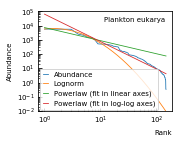

In [8]:
key = 'plankton_eukarya' #'David_stool_A'
title = 'Plankton eukarya'

params = rank_abundance_fit_parameters([key])

abundance = np.copy(df_ts[key].values[0, 1:])
abundance = abundance[abundance > 0]
abundance = np.sort(abundance)[::-1]

rank = np.arange(1,len(abundance)+1)

fig = plt.figure(figsize=(2.5,2), tight_layout=True)
ax = fig.add_subplot(111)
ax.text(0.95, 0.95, title, transform=ax.transAxes,
              va='top', ha='right')

ax.plot(rank, abundance, label='Abundance')

x = np.logspace(0,np.log10(len(abundance)),500)

ax.plot(x, lognormal(x, params['mu_lognormal'].loc[key], 
                     params['sigma_lognormal'].loc[key], 
                     params['scale_lognormal'].loc[key]), label='Lognorm')

ax.plot(x, params['amp_powerlaw'].loc[key]*(x**params['index_powerlaw'].loc[key]), 
        label='Powerlaw (fit in linear axes)')

ax.plot(x, params['amp_powerlaw_linfit'].loc[key]*(x**params['index_powerlaw_linfit'].loc[key]), 
        label='Powerlaw (fit in log-log axes)')

#plt.plot(x, logseries(x, 0.3), label='logseries')

ax.legend(loc=3)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim([1e-2,1e5])

ax.set_xlabel('Rank', ha='right', x=1)
ax.set_ylabel('Abundance')

plt.savefig('figures_elife/supplemental/rank_abundanca_fitting.pdf')
plt.show()

  agg_filter: a filter function, which takes a (m, n, 3) float array and a dpi value, and returns a (m, n, 3) array 
  alpha: float
  animated: bool
  backgroundcolor: color
  bbox: dict with properties for `.patches.FancyBboxPatch`
  clip_box: `matplotlib.transforms.Bbox`
  clip_on: bool
  clip_path: { (`.path.Path`, `.transforms.Transform`), `.patches.Patch`, None } 
  color: color
  contains: callable
  figure: `.Figure`
  fontfamily: {FONTNAME, 'serif', 'sans-serif', 'cursive', 'fantasy', 'monospace'}
  fontname: {FONTNAME, 'serif', 'sans-serif', 'cursive', 'fantasy', 'monospace'}
  fontproperties: `.font_manager.FontProperties`
  fontsize: {size in points, 'xx-small', 'x-small', 'small', 'medium', 'large', 'x-large', 'xx-large'}
  fontstretch: {a numeric value in range 0-1000, 'ultra-condensed', 'extra-condensed', 'condensed', 'semi-condensed', 'normal', 'semi-expanded', 'expanded', 'extra-expanded', 'ultra-expanded'}
  fontstyle: {'normal', 'italic', 'oblique'}
  fontvariant: {'n

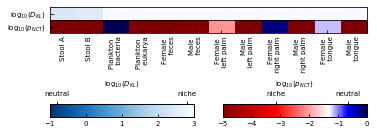

In [27]:
neutrality = pd.read_csv('results/experimental/neutrality.csv', index_col=0)

keys = ['David_stool_A', 'David_stool_B',
        'plankton_bacteria', 'plankton_eukarya',
        'Caporaso_F4_feces_L6', 'Caporaso_M3_feces_L6',
        'Caporaso_F4_L_palm_L6', 'Caporaso_M3_L_palm_L6',
        'Caporaso_F4_R_palm_L6', 'Caporaso_M3_R_palm_L6',
        'Caporaso_F4_tongue_L6', 'Caporaso_M3_tongue_L6']

titles = ['Stool A', 'Stool B', 
          'Plankton \n bacteria', 'Plankton \n eukarya',
          'Female \n feces', 'Male \n feces',
            'Female \n left palm', 'Male \n left palm',
            'Female \n right palm', 'Male \n right palm',
            'Female \n tongue', 'Male \n tongue']

neutrality = neutrality.loc[keys]

fig = plt.figure(figsize=(ELIFE.TEXTWIDTH,1.8), tight_layout=True)

gs1 = gridspec.GridSpec(2,1,hspace=0, left = 0.15, bottom=0.75, top=0.95, right=0.95)
gs2 = gridspec.GridSpec(1,2,wspace=0.2, left = 0.15, top=0.2, bottom=0.1, right=0.95)

ax_KL = fig.add_subplot(gs1[0])
ax_clb_KL = fig.add_subplot(gs2[0])
ax_NCT = fig.add_subplot(gs1[1])
ax_clb_NCT = fig.add_subplot(gs2[1])
ax_KL.set_facecolor('lightgrey')
ax_NCT.set_facecolor('lightgrey')

# KL

KL = np.log10(neutrality['KL'].values.astype(np.float64))
KL = KL.reshape([1, len(KL)])
KL[np.isinf(KL)] = 3.0
mat_KL = ax_KL.matshow(KL, origin='lower', cmap='Blues_r', aspect='auto', vmin=-1, vmax=3)

ax_KL.set_yticks([0])
ax_KL.set_yticklabels([r'log$_{10}$($D_{KL}$)'])

ax_KL.tick_params(axis="both", bottom=False, top=False, labelbottom=False, labeltop=False, left=True, labelleft=True)

fig.colorbar(mat_KL, cax=ax_clb_KL, orientation='horizontal')
ax_clb_KL.set_title(r'log$_{10}$($D_{KL}$)')

# NCT 

NCT = np.log10(neutrality['NCT'].values.astype(np.float64))
NCT = NCT.reshape([1, len(NCT)])

vmin = -5; vmax = 0 # pvalue is max 1 = 1e0
norm = PiecewiseNormalize([vmin, np.log10(0.05), vmax], [0, 0.5, 1])
mat_NCT = ax_NCT.matshow(NCT, origin='lower', norm=norm, 
                     cmap='seismic_r', aspect='auto', vmin=vmin, vmax=vmax)
fig.colorbar(mat_NCT, cax=ax_clb_NCT, orientation='horizontal')

ax_NCT.set_xticks(range(len(NCT[0])))
ax_NCT.set_xticklabels(titles)

ax_NCT.set_yticks([0])
ax_NCT.set_yticklabels([r'log$_{10}$($p_{NCT}$)'],)

# Set ticks on both sides of axes on
ax_NCT.tick_params(axis="both", bottom=True, top=False, labelbottom=True, labeltop=False, left=True, labelleft=True)
ax_clb_NCT.set_title(r'log$_{10}$($p_{NCT}$)')

# Rotate and align bottom ticklabels
plt.setp([tick.label1 for tick in ax_NCT.xaxis.get_major_ticks()], rotation=90,
         ha="right", va="center", rotation_mode="anchor")
plt.setp([tick.label1 for tick in ax_NCT.yaxis.get_major_ticks()])

ax_clb2 = ax_clb_KL.twiny()
ax_clb_KL.xaxis.set_ticks_position('bottom')
ax_clb2.xaxis.set_ticks_position('top')
ax_clb2.xaxis.set_ticks([0.05,0.95])
ax_clb2.set_xlim([0,1])
ax_clb2.xaxis.set_ticklabels(['neutral','niche'])
ax_clb2.tick_params(axis='x', direction='out')

ax_clb2 = ax_clb_NCT.twiny()
ax_clb_NCT.xaxis.set_ticks_position('bottom')
ax_clb2.xaxis.set_ticks_position('top')
ax_clb2.xaxis.set_ticks([1+(vmin + np.log10(0.05))/(vmax - vmin)/2,
                        1+(vmax + np.log10(0.05))/(vmax - vmin)/2])
ax_clb2.set_xlim([0,1])
ax_clb2.xaxis.set_ticklabels(['niche','neutral'])
ax_clb2.tick_params(axis='x', direction='out')

plt.savefig('figures_elife/supplemental/experimental_neutrality2.pdf')
plt.show()

# Large combination figure

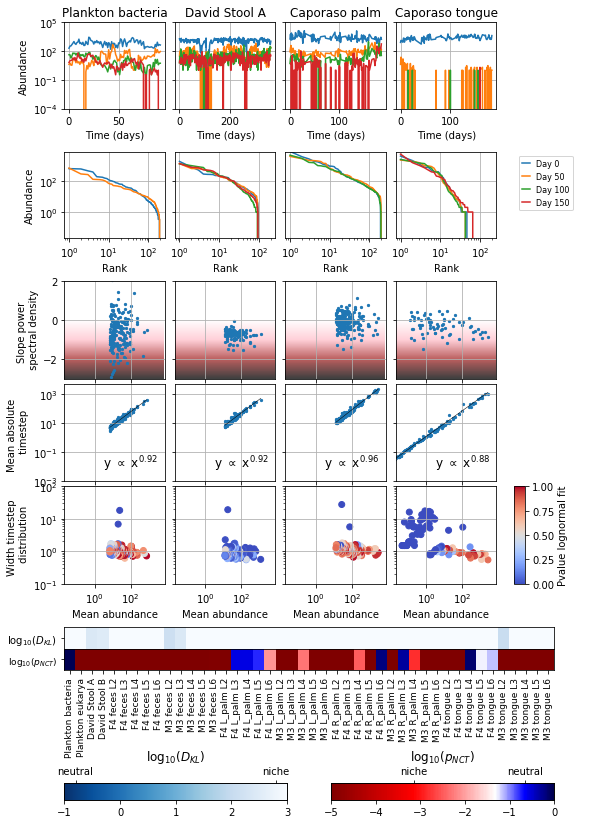

In [15]:
plotts = True
plotra = True
plotnc = True
plotdx = True
plotdisdx = True

keys = ['plankton_bacteria', 'David_stool_A',
        'Caporaso_F4_L_palm_L6', 'Caporaso_F4_tongue_L6']

titles = ['Plankton bacteria', 'David Stool A', 
          'Caporaso palm', 'Caporaso tongue']

fig = plt.figure(figsize=(8,12))

gs_ts = gridspec.GridSpec(2, len(keys), top=0.95, bottom=0.7, left = 0.1, right=0.85, hspace=0.5, wspace=0.1)
gs_ma = gridspec.GridSpec(3, len(keys), top=0.65, bottom=0.3, left = 0.1, right=0.85, hspace=0.05, wspace=0.1)
gs_legend = gridspec.GridSpec(2, 1, top=0.95, bottom=0.7, left = 0.88, right=0.99, hspace=0.5, wspace=0.1)
gs_cbar = gridspec.GridSpec(3, 1, top=0.65, bottom = 0.3, left = 0.88, right=0.9, hspace=0.05, wspace=0.1)

gs1 = gridspec.GridSpec(2,1,hspace=0, left = 0.1, right= 0.95, top=0.25, bottom=0.2) # for neutrality
gs2 = gridspec.GridSpec(1,2,wspace=0.2, left=0.1, right = 0.95, top = 0.07, bottom=0.05) # for colorbars neutrality

#axes = np.empty([5, len(keys)])

axes = [[0 for i in range(len(keys))] for j in range(5)]
for i in range(2):
    for j in range(len(keys)):
        if j == 0: # share axes except for timeseries
            axes[i][j] = fig.add_subplot(gs_ts[i,j])
            if i == 0:
                axes[i][j].set_title(titles[i])
        elif i == 0:
            axes[i][j] = fig.add_subplot(gs_ts[i,j], sharey=axes[i][0])
            axes[i][j].set_title(titles[j])
        else:
            axes[i][j] = fig.add_subplot(gs_ts[i,j], sharey=axes[i][0], sharex=axes[i][0])
        axes[i][j].grid()
        
for i in range(2,5):
    for j in range(len(keys)):
        if i-2 == 0 and j == 0: # share axes except for timeseries
            axes[i][j] = fig.add_subplot(gs_ma[i-2,j])
        elif i-2 == 0:
            axes[i][j] = fig.add_subplot(gs_ma[i-2,j], sharey=axes[i][0])
        elif j == 0:
            axes[i][j] = fig.add_subplot(gs_ma[i-2,j], sharex=axes[i-1][j])
        else:
            axes[i][j] = fig.add_subplot(gs_ma[i-2,j], sharey=axes[i][0], sharex=axes[i-1][j])
        axes[i][j].grid()

axes_cbar = fig.add_subplot(gs_cbar[-1])
axes_legend = fig.add_subplot(gs_legend[-1])
axes_legend.axis('off')

for i, key in enumerate(keys):
    ts = df_ts[key]
    mean = df_ts[key].mean()
    mean.drop('time', inplace=True)
    ts['time'] -= ts['time'].min()
    
    vmin = 2e-2
    vmax = 8e3
    
    def fit_ratio(x):
        x = x[:-1] / x[1:]
        x = x[np.isfinite(x)]

        if len(x) > 5:
            a, b, c = stats.lognorm.fit(x, floc=0)  # Gives the paramters of the fit
            stat, pval = stats.kstest(x, 'lognorm', args=((a, b, c)))

            return a, b, c, stat, pval
        else:
            return (np.nan, np.nan, np.nan, np.nan, np.nan)
        
    # timeseries
    
    if plotts:
        ax = axes[0][i]

        sorted_species = mean.sort_values().index.tolist()[::-1]

        skip = max(1, int(len(ts) / 500))
        for species in sorted_species[::int((len(ts.columns)-1) / 4)]:
            ax.plot(ts['time'][::skip], ts[species][::skip])

        ax.set_xlabel('Time (days)')
        ax.set_yscale('log')
        
    # Rank abundance
    
    if plotra:
        ax = axes[1][i]

        selected_times = np.arange(ts['time'].min(), ts['time'].max(), 50)[:4]

        for t in selected_times:
            abundance_profile = ts[ts['time'] == t].values.flatten()[1:]
            ax.plot(range(1, len(abundance_profile) + 1), np.sort(abundance_profile)[::-1],
                       label='Day %d' % int(t))
        ax.set_xlabel('Rank')
        ax.set_xscale('log')
        ax.set_yscale('log')
        if i == 1:
            handles, labels = ax.get_legend_handles_labels()
            axes_legend.legend(handles, labels, handlelength=1, fontsize=fontsize)
        ax.set_ylim([vmin, vmax])
    
    # Noise color
    
    if plotnc:
        ax = axes[2][i]

        ax.set_xscale('log')

        df_ns = noise_color(ts)
        ns = df_ns['slope_linear']
        sc = ax.scatter(mean, ns, vmin=0, vmax=10, s=5)

        xx = np.linspace(2, -3, 500).reshape([500, 1])
        ax.imshow(xx, cmap=noise_cmap_ww, vmin=noise_lim[0], vmax=noise_lim[1], extent=(vmin, vmax, -3, 2),
                     aspect='auto', alpha=0.75)
        ax.set_xlabel('Abundance')

        ax.set_xticklabels(['']*10) # no ticklabels
        
    # absolute timestep
    
    if plotdx:
        ax = axes[3][i]

        dx = (ts.values[1:, 1:] - ts.values[:-1, 1:])  # / x.values[:-1, 1:];
        dx[~np.isfinite(dx)] = np.nan
        mean_dx = np.nanmean(abs(dx), axis=0)

        p_lin = np.polyfit(np.log10(mean), np.log10(mean_dx), deg=1, cov=False)

        xx = [np.nanmin(mean.values), np.nanmax(mean.values)]
        ax.plot(xx, 10 ** (p_lin[1] + p_lin[0] * np.log10(xx)), c='k', linewidth=0.5)
        ax.annotate(r'y $\propto$ x$^{%.2f}$' % p_lin[0],(3,0.01), fontsize=ELIFE.FONTSIZE)
        ax.scatter(mean, mean_dx, s=5)

        ax.set_xscale('log')
        ax.set_yscale('log')

        ax.set_xlabel('Mean abundance')
        ax.set_xticklabels(['']*10) # no ticklabels
        ax.set_ylim([1e-3, 5e3])
    
    # distribution timestep
    
    if plotdisdx:
        ax = axes[4][i]

        dx_ratio = pd.DataFrame(index=ts.columns, columns=['s', 'loc', 'scale', 'ks-stat', 'ks-pval'])
        dx_ratio.drop('time', inplace=True)

        for idx in dx_ratio.index:
            dx_ratio.loc[idx] = fit_ratio(ts[idx].values)  # b = 0, c = 1

        sc = ax.scatter(mean, dx_ratio['s'], c=dx_ratio['ks-pval'], vmin=0, vmax=1, cmap='coolwarm')

        # ax_disdx.legend()
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.set_xlabel('Mean abundance')

        ax.set_xlim([vmin, vmax])
        ax.set_ylim([1e-1, 1e2])
        
        if i == 0:
            fig.colorbar(sc, cax=axes_cbar)
            axes_cbar.set_ylabel('Pvalue lognormal fit')
        
    if i == 0:
        axes[0][i].set_ylabel('Abundance')
        axes[0][i].set_ylim([1e-4,1e5])
        axes[1][i].set_ylabel('Abundance')
        axes[2][i].set_ylabel('Slope power \n spectral density')
        axes[3][i].set_ylabel('Mean absolute \n timestep')
        axes[4][i].set_ylabel('Width timestep \n distribution')
        axes[4][i].set_xlim([vmin, vmax])
        axes[4][i].set_ylim([vmin, vmax])
    else:
        for j in range(5):
            plt.setp(axes[j][i].get_yticklabels(), visible=False)

# neutrality

if True:
    titles = ['Plankton bacteria', 'Plankton eukarya', 'David Stool A', 'David Stool B']

    areas = ['feces', 'L_palm', 'R_palm', 'tongue']
    gender = ['F4', 'M3']

    for area in areas:
        for gender_i in gender:
            for taxlevel in range(2,7):
                titles += [gender_i + ' ' + area + ' L%d' % taxlevel]

    
neutrality = pd.read_csv('experimental_neutrality.csv')

ax_KL = fig.add_subplot(gs1[0])
ax_clb_KL = fig.add_subplot(gs2[0])
ax_NCT = fig.add_subplot(gs1[1])
ax_clb_NCT = fig.add_subplot(gs2[1])
ax_KL.set_facecolor('lightgrey')
ax_NCT.set_facecolor('lightgrey')

x = np.log10(neutrality['KL'].values.astype(np.float64))
x = x.reshape([1, len(x)])
x[np.isinf(x)] = 3.0
mat_KL = ax_KL.matshow(x, origin='lower', 
                    cmap='Blues_r', aspect='auto', vmin=-1, vmax=3)
ax_KL.set_yticks([0])
ax_KL.set_yticklabels([r'log$_{10}$($D_{KL}$)'], fontsize=fontsize)

ax_KL.tick_params(axis="both", bottom=False, top=False, labelbottom=False, labeltop=False, left=True, labelleft=True)

fig.colorbar(mat_KL, cax=ax_clb_KL, orientation='horizontal')
ax_clb_KL.set_title(r'log$_{10}$($D_{KL}$)')

x = np.log10(neutrality['NCT'].values.astype(np.float64))
x = x.reshape([1, len(x)])

vmin = -5; vmax = 0 # pvalue is max 1 = 1e0
norm = PiecewiseNormalize([vmin, np.log10(0.05), vmax], [0, 0.5, 1])
mat_NCT = ax_NCT.matshow(x, origin='lower', norm=norm, 
                     cmap='seismic_r', aspect='auto', vmin=vmin, vmax=vmax)
fig.colorbar(mat_NCT, cax=ax_clb_NCT, orientation='horizontal')

ax_NCT.set_xticks(range(len(x[0])))
ax_NCT.set_xticklabels(titles)

ax_NCT.set_yticks([0])
ax_NCT.set_yticklabels([r'log$_{10}$($p_{NCT}$)'], fontsize=fontsize)

# Set ticks on both sides of axes on
ax_NCT.tick_params(axis="both", bottom=True, top=False, labelbottom=True, labeltop=False, left=True, labelleft=True)
ax_clb_NCT.set_title(r'log$_{10}$($p_{NCT}$)')

# Rotate and align bottom ticklabels
plt.setp([tick.label1 for tick in ax_NCT.xaxis.get_major_ticks()], rotation=90,
         ha="right", va="center", rotation_mode="anchor", fontsize=fontsize)
plt.setp([tick.label1 for tick in ax_NCT.yaxis.get_major_ticks()], fontsize=fontsize)

ax_clb2 = ax_clb_KL.twiny()
ax_clb_KL.xaxis.set_ticks_position('bottom')
ax_clb2.xaxis.set_ticks_position('top')
ax_clb2.xaxis.set_ticks([0.05,0.95])
ax_clb2.set_xlim([0,1])
ax_clb2.xaxis.set_ticklabels(['neutral','niche'])

ax_clb2 = ax_clb_NCT.twiny()
ax_clb_NCT.xaxis.set_ticks_position('bottom')
ax_clb2.xaxis.set_ticks_position('top')
ax_clb2.xaxis.set_ticks([1+(vmin + np.log10(0.05))/(vmax - vmin)/2,
                        1+(vmax + np.log10(0.05))/(vmax - vmin)/2])
ax_clb2.set_xlim([0,1])
ax_clb2.xaxis.set_ticklabels(['niche','neutral'])

plt.savefig('figures/experimental_summary.pdf')
plt.show()

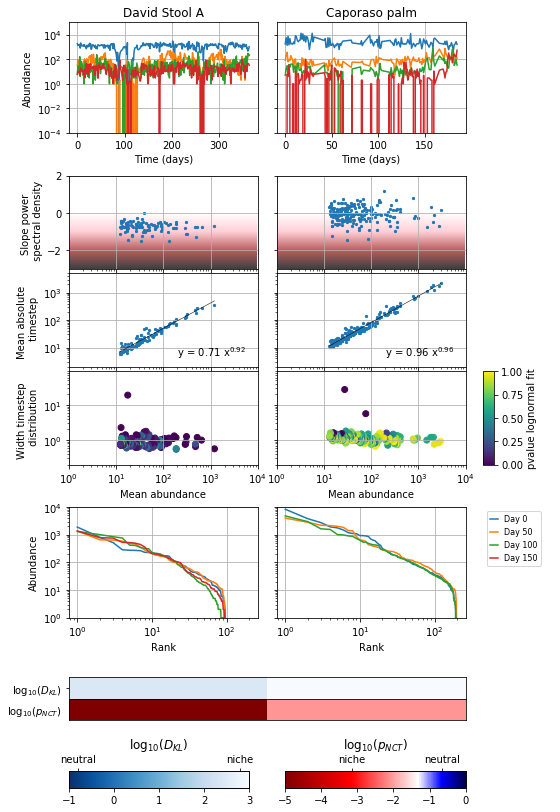

In [58]:
# figure poster

plotts = True
plotra = True
plotnc = True
plotdx = True
plotdisdx = True

keys = ['David_stool_A', 'Caporaso_F4_L_palm_L6']

titles = ['David Stool A', 'Caporaso palm']

fig = plt.figure(figsize=(20/2.54,30/2.54))

gs_ts = gridspec.GridSpec(1, len(keys), top=0.95, bottom=0.82, left = 0.15, right=0.85, hspace=0.5, wspace=0.1)
gs_ma = gridspec.GridSpec(3, len(keys), top=0.77, bottom=0.43, left = 0.15, right=0.85, hspace=0.05, wspace=0.1)
gs_ra = gridspec.GridSpec(1, len(keys), top=0.38, bottom=0.25, left = 0.15, right=0.85, hspace=0.5, wspace=0.1)

gs_legend = gridspec.GridSpec(1, 1, top=0.38, bottom=0.25, left = 0.88, right=0.99, hspace=0.5, wspace=0.1)
gs_cbar = gridspec.GridSpec(3, 1, top=0.77, bottom = 0.43, left = 0.88, right=0.9, hspace=0.05, wspace=0.1)

gs1 = gridspec.GridSpec(2,1,hspace=0, left = 0.15, right= 0.85, top=0.18, bottom=0.13) # for neutrality
gs2 = gridspec.GridSpec(1,2,wspace=0.2, left=0.15, right = 0.85, top = 0.07, bottom=0.05) # for colorbars neutrality

#axes = np.empty([5, len(keys)])

axes = [[0 for i in range(len(keys))] for j in range(5)]
for i in range(1):
    for j in range(len(keys)):
        if j == 0: # share axes except for timeseries
            axes[i][j] = fig.add_subplot(gs_ts[i,j])
            if i == 0:
                axes[i][j].set_title(titles[i])
        elif i == 0:
            axes[i][j] = fig.add_subplot(gs_ts[i,j], sharey=axes[i][0])
            axes[i][j].set_title(titles[j])
        else:
            axes[i][j] = fig.add_subplot(gs_ts[i,j], sharey=axes[i][0], sharex=axes[i][0])
        axes[i][j].grid()

idx_s = 1

for i in range(idx_s, idx_s + 3):
    for j in range(len(keys)):
        if i-idx_s == 0 and j == 0: # share axes except for timeseries
            axes[i][j] = fig.add_subplot(gs_ma[i-idx_s,j])
        elif i-idx_s == 0:
            axes[i][j] = fig.add_subplot(gs_ma[i-idx_s,j], sharey=axes[i][0])
        elif j == 0:
            axes[i][j] = fig.add_subplot(gs_ma[i-idx_s,j], sharex=axes[i-idx_s][j])
        else:
            axes[i][j] = fig.add_subplot(gs_ma[i-idx_s,j], sharey=axes[i][0], sharex=axes[i-idx_s][j])
        axes[i][j].grid()

idx_s = 4
for i in range(idx_s, idx_s + 1):
    for j in range(len(keys)):
        if j == 0: # share axes except for timeseries
            axes[i][j] = fig.add_subplot(gs_ra[i-idx_s,j])
        else:
            axes[i][j] = fig.add_subplot(gs_ra[i-idx_s,j], sharey=axes[i][0], sharex=axes[i][0])
        axes[i][j].grid()
        
axes_cbar = fig.add_subplot(gs_cbar[-1])
axes_legend = fig.add_subplot(gs_legend[-1])
axes_legend.axis('off')

for i, key in enumerate(keys):
    ts = df_ts[key]
    mean = df_ts[key].mean()
    mean.drop('time', inplace=True)
    ts['time'] -= ts['time'].min()
    
    vmin = 1e0 #2e-2
    vmax = 1e4
    
    def fit_ratio(x):
        x = x[:-1] / x[1:]
        x = x[np.isfinite(x)]

        if len(x) > 5:
            a, b, c = stats.lognorm.fit(x, floc=0)  # Gives the paramters of the fit
            stat, pval = stats.kstest(x, 'lognorm', args=((a, b, c)))

            return a, b, c, stat, pval
        else:
            return (np.nan, np.nan, np.nan, np.nan, np.nan)
        
    # timeseries
    
    if plotts:
        ax = axes[0][i]

        sorted_species = mean.sort_values().index.tolist()[::-1]

        skip = max(1, int(len(ts) / 500))
        for species in sorted_species[::int((len(ts.columns)-1) / 4)]:
            ax.plot(ts['time'][::skip], ts[species][::skip])

        ax.set_xlabel('Time (days)')
        ax.set_yscale('log')
    
            
    # Rank abundance
    
    if plotra:
        ax = axes[4][i]

        selected_times = np.arange(ts['time'].min(), ts['time'].max(), 50)[:4]

        for t in selected_times:
            abundance_profile = ts[ts['time'] == t].values.flatten()[1:]
            ax.plot(range(1, len(abundance_profile) + 1), np.sort(abundance_profile)[::-1],
                       label='Day %d' % int(t))
        ax.set_xlabel('Rank')
        ax.set_xscale('log')
        ax.set_yscale('log')
        if i == 1:
            handles, labels = ax.get_legend_handles_labels()
            axes_legend.legend(handles, labels, handlelength=1, fontsize=fontsize)
        ax.set_ylim([vmin, vmax])
    
    # Noise color
    
    if plotnc:
        ax = axes[1][i]

        ax.set_xscale('log')

        df_ns = noise_color(ts)
        ns = df_ns['slope_linear']
        sc = ax.scatter(mean, ns, vmin=0, vmax=10, s=5)

        xx = np.linspace(2, -3, 500).reshape([500, 1])
        ax.imshow(xx, cmap=noise_cmap_ww, vmin=noise_lim[0], vmax=noise_lim[1], extent=(vmin, vmax, -3, 2),
                     aspect='auto', alpha=0.75)
        ax.set_xlabel('Abundance')

        ax.set_xticklabels(['']*10) # no ticklabels
        
    # absolute timestep
    
    if plotdx:
        ax = axes[2][i]

        dx = (ts.values[1:, 1:] - ts.values[:-1, 1:])  # / x.values[:-1, 1:];
        dx[~np.isfinite(dx)] = np.nan
        mean_dx = np.nanmean(abs(dx), axis=0)

        p_lin = np.polyfit(np.log10(mean), np.log10(mean_dx), deg=1, cov=False)

        xx = [np.nanmin(mean.values), np.nanmax(mean.values)]
        ax.plot(xx, 10 ** (p_lin[1] + p_lin[0] * np.log10(xx)), c='k', linewidth=0.5)
        ax.annotate(r'y = %.2f x$^{%.2f}$' % (10**p_lin[1], p_lin[0]), (200,5), fontsize=ELIFE.FONTSIZE)
        ax.scatter(mean, mean_dx, s=5)

        ax.set_xscale('log')
        ax.set_yscale('log')

        ax.set_xlabel('Mean abundance')
        ax.set_xticklabels(['']*10) # no ticklabels
        ax.set_ylim([2e0, 5e3])
    
    # distribution timestep
    
    if plotdisdx:
        ax = axes[3][i]

        dx_ratio = pd.DataFrame(index=ts.columns, columns=['s', 'loc', 'scale', 'ks-stat', 'ks-pval'])
        dx_ratio.drop('time', inplace=True)

        for idx in dx_ratio.index:
            dx_ratio.loc[idx] = fit_ratio(ts[idx].values)  # b = 0, c = 1

        sc = ax.scatter(mean, dx_ratio['s'], c=dx_ratio['ks-pval'], vmin=0, vmax=1)

        # ax_disdx.legend()
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.set_xlabel('Mean abundance')

        ax.set_xlim([vmin, vmax])
        ax.set_ylim([2e-1, 9e1])
        
        if i == 0:
            fig.colorbar(sc, cax=axes_cbar)
            axes_cbar.set_ylabel('pvalue lognormal fit')
        
    if i == 0:
        axes[0][i].set_ylabel('Abundance')
        axes[0][i].set_ylim([1e-4,1e5])
        axes[1][i].set_ylabel('Slope power \n spectral density')
        axes[2][i].set_ylabel('Mean absolute \n timestep')
        axes[3][i].set_ylabel('Width timestep \n distribution')
        axes[3][i].set_xlim([vmin, vmax])
        axes[3][i].set_ylim([vmin, vmax])
        axes[4][i].set_ylabel('Abundance')
    else:
        for j in range(5):
            plt.setp(axes[j][i].get_yticklabels(), visible=False)
    for j in range(1,3):
        plt.setp(axes[j][i].get_xticklabels(), visible=False)


# neutrality

if True:
    titles = ['Plankton bacteria', 'Plankton eukarya', 'David Stool A', 'David Stool B']

    areas = ['feces', 'L_palm', 'R_palm', 'tongue']
    gender = ['F4', 'M3']

    for area in areas:
        for gender_i in gender:
            for taxlevel in range(2,7):
                titles += [gender_i + ' ' + area + ' L%d' % taxlevel]

neutrality = pd.read_csv('experimental_neutrality.csv', index_col=0)

neutrality = neutrality.loc[keys]

ax_KL = fig.add_subplot(gs1[0])
ax_clb_KL = fig.add_subplot(gs2[0])
ax_NCT = fig.add_subplot(gs1[1])
ax_clb_NCT = fig.add_subplot(gs2[1])
ax_KL.set_facecolor('lightgrey')
ax_NCT.set_facecolor('lightgrey')

x = np.log10(neutrality['KL'].values.astype(np.float64))
x = x.reshape([1, len(x)])
x[np.isinf(x)] = 3.0
mat_KL = ax_KL.matshow(x, origin='lower', 
                    cmap='Blues_r', aspect='auto', vmin=-1, vmax=3)
ax_KL.set_yticks([0])
ax_KL.set_yticklabels([r'log$_{10}$($D_{KL}$)'], fontsize=fontsize)

ax_KL.tick_params(axis="both", bottom=False, top=False, labelbottom=False, labeltop=False, left=True, labelleft=True)

fig.colorbar(mat_KL, cax=ax_clb_KL, orientation='horizontal')
ax_clb_KL.set_title(r'log$_{10}$($D_{KL}$)')

x = np.log10(neutrality['NCT'].values.astype(np.float64))
x = x.reshape([1, len(x)])

vmin = -5; vmax = 0 # pvalue is max 1 = 1e0
norm = PiecewiseNormalize([vmin, np.log10(0.05), vmax], [0, 0.5, 1])
mat_NCT = ax_NCT.matshow(x, origin='lower', norm=norm, 
                     cmap='seismic_r', aspect='auto', vmin=vmin, vmax=vmax)
fig.colorbar(mat_NCT, cax=ax_clb_NCT, orientation='horizontal')

ax_NCT.set_xticks(range(len(x[0])))
ax_NCT.set_xticklabels(titles)

ax_NCT.set_yticks([0])
ax_NCT.set_yticklabels([r'log$_{10}$($p_{NCT}$)'], fontsize=fontsize)

# Set ticks on both sides of axes on
ax_NCT.tick_params(axis="both", bottom=False, top=False, labelbottom=False, labeltop=False, left=False, labelleft=True)
ax_clb_NCT.set_title(r'log$_{10}$($p_{NCT}$)')

ax_clb2 = ax_clb_KL.twiny()
ax_clb_KL.xaxis.set_ticks_position('bottom')
ax_clb2.xaxis.set_ticks_position('top')
ax_clb2.xaxis.set_ticks([0.05,0.95])
ax_clb2.set_xlim([0,1])
ax_clb2.xaxis.set_ticklabels(['neutral','niche'])

ax_clb2 = ax_clb_NCT.twiny()
ax_clb_NCT.xaxis.set_ticks_position('bottom')
ax_clb2.xaxis.set_ticks_position('top')
ax_clb2.xaxis.set_ticks([1+(vmin + np.log10(0.05))/(vmax - vmin)/2,
                        1+(vmax + np.log10(0.05))/(vmax - vmin)/2])
ax_clb2.set_xlim([0,1])
ax_clb2.xaxis.set_ticklabels(['niche','neutral'])

plt.savefig('figures/experimental_poster.pdf')
plt.show()

# Covariance

David_stool_A
Caporaso_F4_L_palm_L6


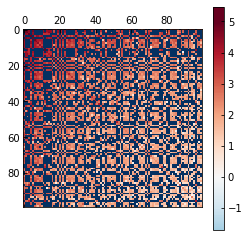

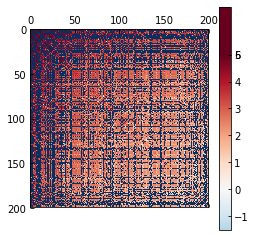

[[6.13E+06 -8.60E+04 1.49E+06]
 [-8.60E+04 3.70E+06 4.41E+05]
 [1.49E+06 4.41E+05 1.48E+06]]


In [18]:
keys = ['David_stool_A', 'Caporaso_F4_L_palm_L6']

titles = ['David Stool A', 'Caporaso palm']

for i, key in enumerate(keys):
    print(key)
    ts = df_ts[key].drop('time', axis=1)
    cov = np.cov(ts.values.T)
    
    norm = PiecewiseNormalize([-5, 0, 5], [0, 0.5, 1])
    
    plt.matshow(np.log10(cov), cmap='RdBu_r', norm=norm)
    plt.colorbar()

plt.show()
print(cov[:3,:3])